# Image Generation with Variational Autoencoders

We'll build a variational autoencoder (VAE) to generate images of handwritten digits inspired by the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset:

In [1]:
import os

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

base_dir = os.path.join("MNIST_dataset", "mnist", "train")

print(f"{len(os.listdir(base_dir))} training images")

60000 training images


We load the data using `Deeptrack2.0`. We will only use `6000` images for training and `6000` for test. We normalize the images in the range `[0, 1]`

In [3]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

paths = dt.sources.ImageFolder(root=base_dir)
train_paths, _, test_paths = dt.sources.random_split(paths, [0.1, 0.8, 0.1])

sources = dt.sources.Sources(train_paths, test_paths)

pipeline = (
    dt.LoadImage(sources.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

2024-01-10 14:31:48.466670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will randomly choose and visualize some of the images in the dataset

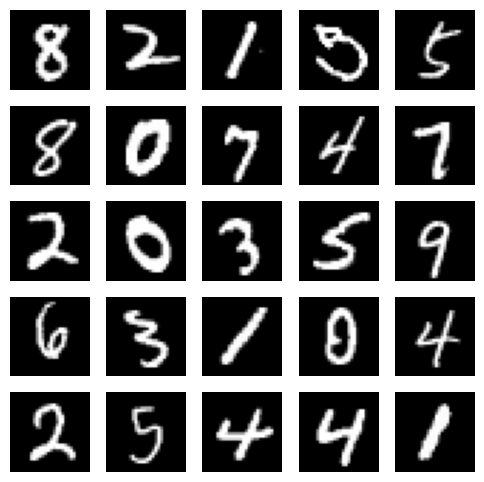

In [4]:
import matplotlib.pyplot as plt
from numpy import squeeze, random

fig, axs = plt.subplots(5, 5, figsize=((6, 6)))
for i, source in enumerate(random.choice(train_paths, 25)):
    image = pipeline(source)
    axs[i // 5, i % 5].imshow(squeeze(image), cmap="gray")
    axs[i // 5, i % 5].set_axis_off()

## Variational autoencoder
We define the autoencoder architecture with a bidimensional latent space.

In [5]:
import deeplay as dl
import torchmetrics as tm

vae = dl.VariationalAutoEncoder(latent_dim=2).create()

print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_f

We define the datasets, the dataloader and the trainer. We train the autoencder for `100` epochs.

In [6]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(pipeline & pipeline, inputs=train_paths)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

vae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")
vae_trainer.fit(vae, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name   

Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Image Generation
We generate images by sampling a continuous distribution of latent representations and reconstructing the images using the trained VAE’s decoder.

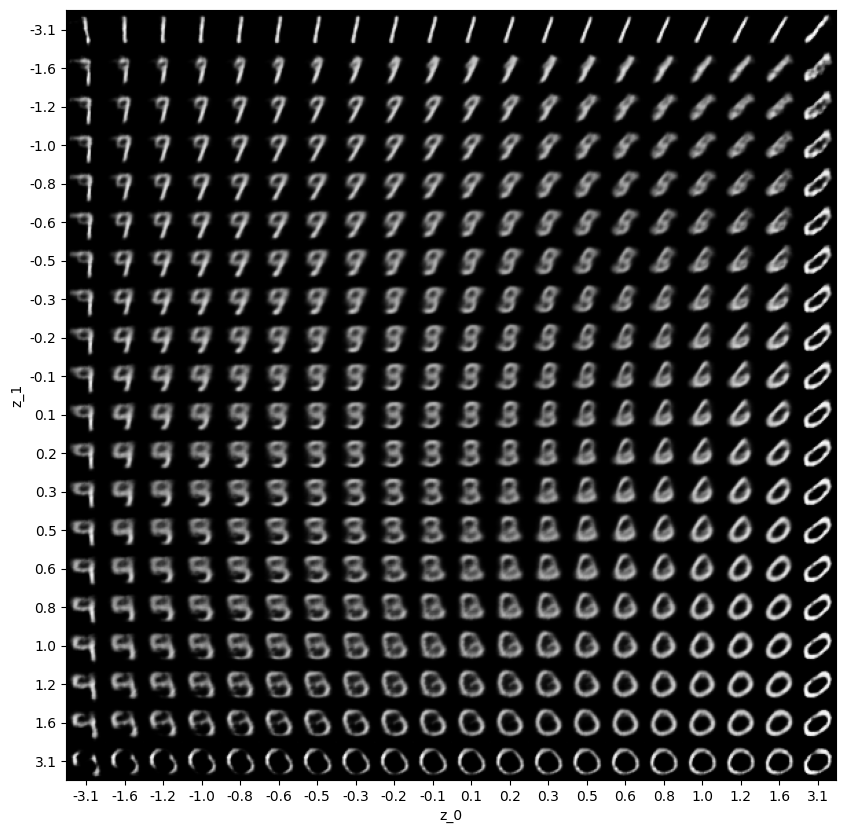

In [7]:
from torch.distributions.normal import Normal
import numpy as np

NUM_OF_IMAGES = 20
IMG_SIZE = 28
norm = Normal(0, 1)
grid_x = norm.icdf(torch.linspace(0.001, 0.999, NUM_OF_IMAGES))
grid_y = norm.icdf(torch.linspace(0.001, 0.999, NUM_OF_IMAGES))

image = np.zeros((IMG_SIZE * NUM_OF_IMAGES,) * 2)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z = torch.stack((xi, yi)).unsqueeze(0)
        gimg = vae.decode(z).clone().detach()
        image[
            i * IMG_SIZE : (i + 1) * IMG_SIZE,
            j * IMG_SIZE : (j + 1) * IMG_SIZE,
        ] = gimg.numpy().squeeze()
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
start = IMG_SIZE // 2
end = NUM_OF_IMAGES * IMG_SIZE + start
pixel_range = np.arange(start, end, IMG_SIZE)
sample_range_x = np.round(grid_x.numpy(), 1)
sample_range_y = np.round(grid_y.numpy(), 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z_0")
plt.ylabel("z_1")
plt.show()

## Clustering in the latent space
We will use the VAE as a clustering algorithm, i.e., to cluster the input images into different classes with respect to the latent space encoding.

We define a pipeline to get images and labels of the test dataset.

In [8]:
def get_label(label_name):
    return int(label_name[0])


label = (
    dt.Value(get_label, label_name=sources.label_name)
    >> dt.Unsqueeze(0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

test_dataset = dt.pytorch.Dataset(pipeline & label, inputs=test_paths)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We encode the images of the test dataset into latent space representation.

In [12]:
mu, test_labels = [], []
for x, y in test_loader:
    m, _ = vae.encode(x)
    mu.append(m)
    test_labels.append(y)
mu = torch.cat(mu, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

We plot the latent-space representation, color coded according to the image label.

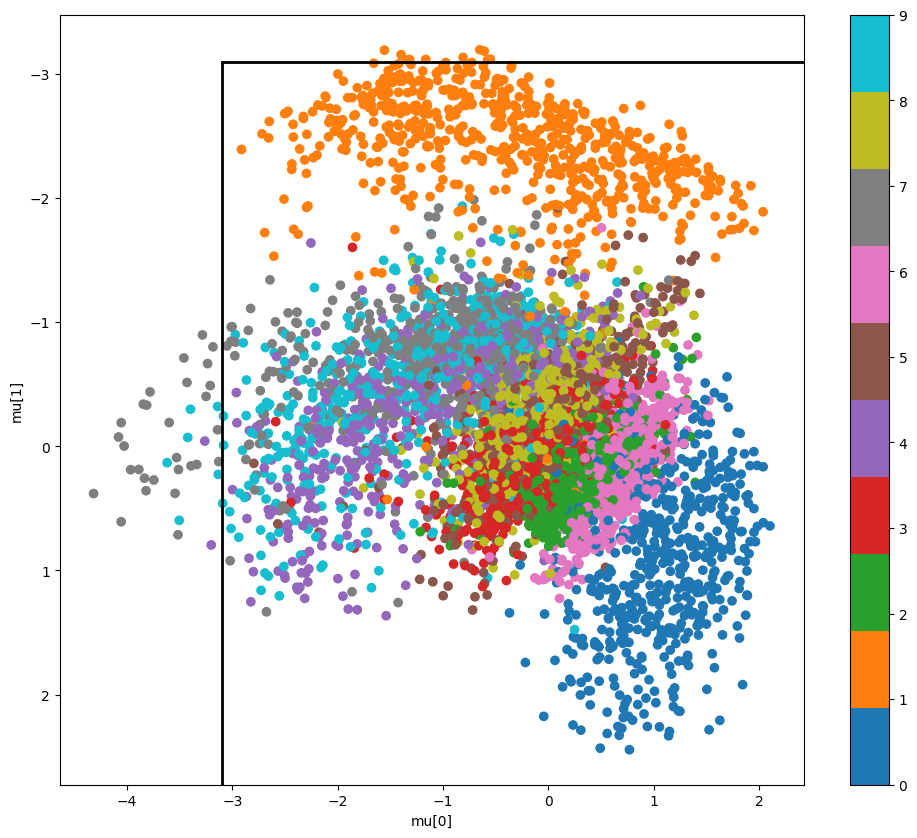

In [13]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
plt.scatter(
    mu[:, 0],
    mu[:, 1],
    c=test_labels,
    cmap="tab10",
)
plt.xlabel("mu[0]")
plt.ylabel("mu[1]")
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, facecolor="none", ec="k", lw=2))
plt.show()

In [ ]:
from deeptrack.models.vaes import VAE

model = VAE(latent_dim=2)

In [ ]:
# model.encoder.summary()
model.decoder.summary()

We define the loss and the optimizer...

... and start the training.

In [ ]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

autoencoder_trainer.fit(autoencoder_regressor, train_loader)

We visualize the autoencoder predictions.

In [ ]:
import matplotlib.pyplot as plt


for i in range(2):
    input_im, target_im = test_dataset[i]
    predicted_im = autoencoder_regressor(input_im).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

The training images are very similar. It can be that the autoencoder just learn to provide a centered particle, no matter what is the input (mode collapse). Let's check it out by making a prediction out of noise. 

Let's see if the autoencoder is able to generalize its predictions to particles located off center and with different size.

We check the predictions on this more challenging test set.

In [ ]:
for _ in range(3):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = autoencoder_regressor(input_im.unsqueeze(0)).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

We can train on the new dataset.

In [ ]:
new_train_dataset = SimulatedDatasetwithReplacement(
    new_pipeline, data_size=256, replace=0.2
)

new_train_loader = DataLoader(new_train_dataset, batch_size=8, shuffle=True)

new_autoencoder_regressor = regressor_template.create()

new_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

new_autoencoder_trainer.fit(new_autoencoder_regressor, new_train_loader)

In [ ]:
import matplotlib.pyplot as plt


for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = new_autoencoder_regressor(input_im.unsqueeze(0)).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

## Improving the predictions
We can use a model with a larger number of activations to improve the results.

In [ ]:
import deeplay as dl
from torch.nn import Sigmoid

better_autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[8, 16, 32],
    decoder_channels=[32, 16, 8],
    out_channels=1,
    out_activation=Sigmoid,
)
print(better_autoencoder)

In [ ]:
better_regressor_template = dl.Regressor(
    model=better_autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

better_autoencoder_regressor = better_regressor_template.create()

better_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

better_autoencoder_trainer.fit(better_autoencoder_regressor, new_train_loader)

In [ ]:
for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = better_autoencoder_regressor(input_im.unsqueeze(0)).detach()

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")